# Init Cells

In [ ]:
# Library Imports
import pandas as pd
import requests
import json
import subprocess
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time

# Run the system

import os
import threading

import glob
import os
import tarfile

import os
import glob
import tarfile
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
# Init functions
def get_pub_ip_addr_and_port(name):
    temp = !kubectl get services --all-namespaces
    node_port = ""
    for line in temp:
        if name in line:
            parts = line.split()
            if len(parts) >= 6:
                node_port = parts[5].split(':')[1].split('/')[0]  # Extract NodePort
    temp = !kubectl get pods -o wide | findstr /R {name}
    node_name = temp[0].split()[6]  # Node name is the 7th column (index 6)
    temp = !kubectl get nodes -o wide | findstr /R {node_name}
    pub_ip = temp[0].split()[6]  # Public IP is the
    return f"{pub_ip}:{node_port}"

def get_inf_ipaddress():
    # Get all pods in all namespaces in JSON format
    result = subprocess.run(
        ["kubectl", "get", "pods", "-A", "-o", "json"],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        check=True
    )
    pods_info = json.loads(result.stdout)
    pod_ips = []
    for item in pods_info.get("items", []):
        metadata = item.get("metadata", {})
        name = metadata.get("name", "")
        status = item.get("status", {})
        pod_ip = status.get("podIP")
        if "api-inferencia" in name and pod_ip:
            pod_ips.append(pod_ip)
    return pod_ips

def copy_file_to_docker(file_path, docker_path):
    """Copy a file from local to GCP VM and then into the Docker container."""
    filename = file_path.split("/")[-1] if "/" in file_path else file_path.split("\\")[-1]
    app_data_path = !dir "%APPDATA%"
    app_data_path = app_data_path[3].split()[-1]
    app_data_path = app_data_path.replace("\\", "/")
    username = app_data_path.split("/")[2]
    # Copy file to VM
    !gcloud compute scp --zone=us-central1-a {file_path} load-testing-instance:/home/{username}
    # Copy file from VM to Docker container
    copy_command = f"docker cp /home/{username}/{filename} load-testing-container:{docker_path}"
    !gcloud compute ssh load-testing-instance --zone=us-central1-a --command="{copy_command}"

def run_docker_command(inner_command):
    """
    Run a command inside load-testing-container on the GCP VM via SSH using docker exec.
    """
    docker_exec_template = "docker exec load-testing-container bash -c '{cmd}'"
    docker_command = docker_exec_template.format(cmd=inner_command)
    ssh_command = f"gcloud compute ssh load-testing-instance --zone=us-central1-a --command=\"{docker_command}\""
    !{ssh_command}

def copy_dir_to_docker(dir_path, docker_path):
    """Copy a directory from local to GCP VM and then into the Docker container."""
    dir_name = dir_path.split("/")[-1] if "/" in dir_path else dir_path.split("\\")[-1]
    username = dir_path.split("/")[2] if "/" in dir_path else dir_path.split("\\")[-2]
    # Clean up the VM directory 
    rm_command = f"sudo rm -rf /home/{username}/{dir_name}"  # Clean up the VM directory after copying
    docker_rm_command = f"docker exec load-testing-container rm -rf {docker_path}{dir_name}"  # Clean up the Docker directory
    !gcloud compute ssh load-testing-instance --zone=us-central1-a --command="{rm_command}"
    !gcloud compute ssh load-testing-instance --zone=us-central1-a --command="{docker_rm_command}"
    # Copy directory to VM
    print(f"gcloud compute scp --zone=us-central1-a --recurse {dir_path} load-testing-instance:/home/{username}/")
    !gcloud compute scp --zone=us-central1-a --recurse {dir_path} load-testing-instance:/home/{username}/
    # Copy directory from VM to Docker container
    copy_command = f"docker cp /home/{username}/{dir_name} load-testing-container:{docker_path}"
    !gcloud compute ssh load-testing-instance --zone=us-central1-a --command="{copy_command}"

def run_vm_command(command):
    """
    Run a command on the GCP VM via SSH.
    """
    ssh_command = f"gcloud compute ssh load-testing-instance --zone=us-central1-a --command=\"{command}\""
    result = !{ssh_command}
    return result

def copy_docker_file_to_local(docker_path, local_path):
    """Copy a file or directory from the Docker container to local."""
    # Get username from VM
    app_data_path = !dir "%APPDATA%"
    app_data_path = app_data_path[3].split()[-1]
    app_data_path = app_data_path.replace("\\", "/")
    username = app_data_path.split("/")[2]
    filename = docker_path.split("/")[-1] if "/" in docker_path else docker_path.split("\\")[-1]
    
    # Copy file from Docker container to VM home directory
    copy_command = f"docker cp load-testing-container:{docker_path} /home/{username}/{filename}"
    !gcloud compute ssh load-testing-instance --zone=us-central1-a --command="{copy_command}"
    # Copy file from VM to local
    copy_command = f"gcloud compute scp --zone=us-central1-a load-testing-instance:/home/{username}/{filename} {local_path}"
    !{copy_command}

# Init Infrastructure

In [3]:
# Get GCloud configuration
projects = !gcloud config get-value project
!gcloud config set project {projects[0]}
!gcloud container clusters get-credentials two-node-cluster --zone us-central1-a

Updated property [core/project].
Fetching cluster endpoint and auth data.
kubeconfig entry generated for two-node-cluster.


In [4]:
# Get the nodes names
nodes = !kubectl get nodes
first_node = nodes[1].split()[0]
second_node = nodes[2].split()[0]
print(f"First node: {first_node}")
print(f"Second node: {second_node}")

First node: gke-two-node-cluster-node-pool-1-a8209908-0c5n
Second node: gke-two-node-cluster-node-pool-1-a8209908-vz7g


In [5]:
# Change node names in yaml files

import yaml

dir_yaml = '../terraform_stuff/deploy_real_kubernetes/'

# FIRST NODE
with open(dir_yaml + 'deploy_micro_inf.yaml', 'r') as filename:
    micro_inf_configs = list(yaml.safe_load_all(filename))
micro_inf_configs[0]['spec']['template']['spec']['nodeName'] = first_node
with open(dir_yaml + 'deploy_micro_inf.yaml', 'w') as filename:
    yaml.safe_dump_all(micro_inf_configs, filename)

with open(dir_yaml + '04-mlflow.yaml', 'r') as filename:
    mlflow_configs = list(yaml.safe_load_all(filename))
mlflow_configs[2]['spec']['template']['spec']['nodeName'] = first_node
with open(dir_yaml + '04-mlflow.yaml', 'w') as filename:
    yaml.safe_dump_all(mlflow_configs, filename)

# SECOND NODE
with open(dir_yaml + '01-zookeeper.yaml', 'r') as filename:
    zookeeper_configs = list(yaml.safe_load_all(filename))
zookeeper_configs[1]['spec']['template']['spec']['nodeName'] = second_node
with open(dir_yaml + '01-zookeeper.yaml', 'w') as filename:
    yaml.safe_dump_all(zookeeper_configs, filename)

with open(dir_yaml + '02-kafka.yaml', 'r') as filename:
    kafka_configs = list(yaml.safe_load_all(filename))
kafka_configs[1]['spec']['template']['spec']['nodeName'] = second_node
with open(dir_yaml + '02-kafka.yaml', 'w') as filename: 
    yaml.safe_dump_all(kafka_configs, filename)

with open(dir_yaml + 'deploy_micro_up.yaml', 'r') as filename:
    micro_up_configs = list(yaml.safe_load_all(filename))
micro_up_configs[0]['spec']['template']['spec']['nodeName'] = second_node
with open(dir_yaml + 'deploy_micro_up.yaml', 'w') as filename:
    yaml.safe_dump_all(micro_up_configs, filename)

In [6]:
# Apply yaml files
dir_yaml = '../terraform_stuff/deploy_real_kubernetes/'
import os

files = [f for f in os.listdir(dir_yaml) if os.path.isfile(os.path.join(dir_yaml, f))]
for file in files:
    if file.endswith('.yaml'):
        print(f'Applying {file}...')
        !kubectl apply -f {os.path.join(dir_yaml, file)}
    else:
        print(f'Skipping {file}, not a YAML file.')

Applying 00-namespace.yaml...
namespace/kafka created
Applying 01-zookeeper.yaml...
service/zookeeper-service created
deployment.apps/zookeeper created
Applying 02-kafka.yaml...
service/kafka-service created
deployment.apps/kafka-broker created
Applying 04-mlflow.yaml...
persistentvolumeclaim/mlflow-pvc created
service/mlflow created
deployment.apps/mlflow created
Applying api_inference_svc.yaml...


Error from server: error when creating "../terraform_stuff/deploy_real_kubernetes/04-mlflow.yaml": admission webhook "warden-mutating.common-webhooks.networking.gke.io" denied the request: GKE Warden rejected the request because it violates one or more mutators.
Violations details: ["error querying GCE PD volume mlflow-disk: disk is not found"]
Requested by user: 'AdilMuhammad706@gmail.com', groups: 'system:authenticated'.


service/api-inferencia created
Applying api_update_svc.yaml...
service/api-update created
Applying deploy_micro_inf.yaml...
deployment.apps/api-inferencia created
persistentvolumeclaim/api-inferencia-pvc created
Applying deploy_micro_up.yaml...


Error from server: error when creating "../terraform_stuff/deploy_real_kubernetes/deploy_micro_inf.yaml": admission webhook "warden-mutating.common-webhooks.networking.gke.io" denied the request: GKE Warden rejected the request because it violates one or more mutators.
Violations details: ["error querying GCE PD volume api-update-disk: disk is not found"]
Requested by user: 'AdilMuhammad706@gmail.com', groups: 'system:authenticated'.


deployment.apps/api-update created
persistentvolumeclaim/api-update-pvc created
Skipping node1.txt, not a YAML file.


Error from server: error when creating "../terraform_stuff/deploy_real_kubernetes/deploy_micro_up.yaml": admission webhook "warden-mutating.common-webhooks.networking.gke.io" denied the request: GKE Warden rejected the request because it violates one or more mutators.
Violations details: ["error querying GCE PD volume api-update-disk: disk is not found"]
Requested by user: 'AdilMuhammad706@gmail.com', groups: 'system:authenticated'.


In [7]:
# Run load testing VM
!gcloud compute instances start load-testing-instance --zone=us-central1-a

Starting instance(s) load-testing-instance...
..........................................................................................................................................................done.
Updated [https://compute.googleapis.com/compute/v1/projects/fast-learner-project/zones/us-central1-a/instances/load-testing-instance].
Instance internal IP is 10.128.0.17
Instance external IP is 34.68.255.201


In [ ]:
# Wait until VM is ready

is_vm_ready = run_vm_command('echo "VM_is_ready"')
while is_vm_ready[0].strip() != "VM_is_ready":
    print("Waiting for VM to be ready...")
    time.sleep(1)
    is_vm_ready = run_vm_command('echo "VM_is_ready"')

In [14]:
# Run load testing container
# docker_command = "docker start -d --name load-testing-container auliadil/load-testing-rodrigues:v1 tail -f /dev/null"
docker_command = "docker start load-testing-container"
gcloud_template = "gcloud compute ssh load-testing-instance --zone=us-central1-a"
!{gcloud_template} --command="{docker_command}"

load-testing-container


In [15]:
# Copy GCloud to Docker VM

app_data_path = !dir "%APPDATA%"
!rmdir /s /q %APPDATA%\gcloud\logs
app_data_path = app_data_path[3].split()[-1]
app_data_path = app_data_path.replace("\\", "/")
copy_dir_to_docker(f'{app_data_path}/gcloud', "/root/.config/gcloud")

projects = !gcloud config get-value project
set_project_command = f"gcloud config set project {projects[0]}"
get_kubectl_command = "gcloud container clusters get-credentials two-node-cluster --zone us-central1-a"
run_docker_command(set_project_command)
run_docker_command(get_kubectl_command)
run_docker_command("kubectl get pods")

gcloud compute scp --zone=us-central1-a --recurse C:/Users/muhammad.aulia/AppData/Roaming/gcloud load-testing-instance:/home/muhammad.aulia/

.last_opt_in_prompt.yaml  | 0 kB |   0.0 kB/s | ETA: 00:00:00 | 100%

.last_survey_prompt.yaml  | 0 kB |   0.0 kB/s | ETA: 00:00:00 | 100%

.last_update_check.json   | 0 kB |   0.2 kB/s | ETA: 00:00:00 | 100%

access_tokens.db          | 4 kB |   4.0 kB/s | ETA: 00:00:02 |  33%
access_tokens.db          | 12 kB |  12.0 kB/s | ETA: 00:00:00 | 100%

active_config             | 0 kB |   0.0 kB/s | ETA: 00:00:00 | 100%

application_default_crede | 0 kB |   0.4 kB/s | ETA: 00:00:00 | 100%

resource.cache            | 4 kB |   4.0 kB/s | ETA: 00:00:02 |  33%
resource.cache            | 12 kB |  12.0 kB/s | ETA: 00:00:00 | 100%

config_default            | 0 kB |   0.1 kB/s | ETA: 00:00:00 | 100%

credentials.db            | 4 kB |   4.0 kB/s | ETA: 00:00:02 |  33%
credentials.db            | 12 kB |  12.0 kB/s | ETA: 00:00:00 | 100%

default_configs.db

pscp: C:/Users/muhammad.aulia/AppData/Roaming/gcloud/logs/2025.08.25/19.51.57.999727.log: Cannot open file

ERROR: (gcloud.compute.scp) [C:\Users\muhammad.aulia\AppData\Local\Google\Cloud SDK\google-cloud-sdk\bin\sdk\pscp.exe] exited with return code [1].
Updated property [core/project].
Fetching cluster endpoint and auth data.
kubeconfig entry generated for two-node-cluster.


NAME                              READY   STATUS    RESTARTS   AGE
api-inferencia-7f479f88df-2qh44   1/1     Running   0          9m37s
api-inferencia-7f479f88df-52l5l   1/1     Running   0          9m37s
api-inferencia-7f479f88df-xjjmg   1/1     Running   0          9m37s
api-inferencia-7f479f88df-xwx7l   1/1     Running   0          9m37s
api-update-5fbd87949c-bqkll       1/1     Running   0          9m34s
mlflow-77888567b5-b4dgq           1/1     Running   0          9m43s


In [32]:
# Copy Files to Pods

pods = !kubectl get pods | findstr /R "upd"
!kubectl cp ../temp/upd/API_update_V8.1.py {pods[0].split()[0]}:/app/API_update_V8.1.py 
!kubectl cp ../temp/upd/API_update_V8.1_HT.py {pods[0].split()[0]}:/app/API_update_V8.1_HT.py 
# !kubectl cp ../temp/upd/API_update_V8.1_debug.py {pods[0].split()[0]}:/app/API_update_V8.1_debug.py 

pods = !kubectl get pods | findstr /R "inf"
!kubectl cp ../temp/inf/API_inferencia_V8.0.py {pods[0].split()[0]}:/app/API_inferencia_V8.0.py


In [33]:
# Copy training data to pods
pods = !kubectl get pods | findstr /R "upd"
!kubectl cp ../../Datasets/real_usage/AGR_a_first_train.csv {pods[0].split()[0]}:/app/AGR_a_first_train.csv
!kubectl cp ../../Datasets/real_usage/AGR_g_first_train.csv {pods[0].split()[0]}:/app/AGR_g_first_train.csv

# Destroy Infrastructure

In [1]:
# Delete load-testing-instance
!gcloud compute instances stop load-testing-instance --zone=us-central1-a

Stopping instance(s) load-testing-instance...
...........done.
Updated [https://compute.googleapis.com/compute/v1/projects/fast-learner-project/zones/us-central1-a/instances/load-testing-instance].


# Init Variables

In [ ]:
# Variables
experiments = [
    # ["AGR_g-HT-old-1000", "AGR_g_real_test.csv"],
    # ["AGR_g-HT-old-2000", "AGR_g_real_test.csv"],
    # ["AGR_g-HT-old-10000", "AGR_g_real_test.csv"],
    # ["AGR_g-HT-1new-0", "AGR_g_real_test.csv"],
    ["AGR_a-HT-1new-0", "AGR_a_real_test.csv", 1000],
    # ["AGR_a-HT-old-1000", "AGR_a_real_test.csv", 1000], 
    # ["AGR_a-HT-old-1000", "AGR_a_real_test.csv", 30000], 
    # ["AGR_a-HT-old-2000", "AGR_a_real_test.csv"],
    # ["AGR_a-HT-old-10000", "AGR_a_real_test.csv"],
    # ["AGR_a-HT-old-1000", "AGR_a_real_test.csv"],
    # ["AGR_a-HT-old-1000", "AGR_a_real_test.csv"],

    # HARUS DIULANGGGG
    # ["AGR_a-HT-1new-0", "AGR_a_real_test.csv", 1000],

    # ["AGR_g-HT-1new-0", "AGR_g_real_test.csv", 1000],
]

update_python_file = "API_update_V8.1.py"

is_stop_system = True

is_copy_locust = True
is_copy_kafka_lag = False

# Run System

In [18]:
# Stop the system

if is_stop_system:

    dir_yaml = '../terraform_stuff/deploy_real_kubernetes/'

    # Restart Kafka
    !kubectl delete -f {dir_yaml}/02-kafka.yaml
    !kubectl apply -f {dir_yaml}/02-kafka.yaml

    # Stop inference and update pods
    inference_pods = !kubectl get pods | findstr /R "inf"
    update_pods = !kubectl get pods | findstr /R "upd"
    for pod in inference_pods:
        !kubectl exec {pod.split()[0]} -- pkill -f API
    for pod in update_pods:
        !kubectl exec {pod.split()[0]} -- pkill -f API

    # Stop load testing
    run_docker_command("pkill -f check-kafka-lag.py")
    run_docker_command("pkill -f locust-testing.py")

kafka_pods = !kubectl get pods -n kafka | findstr /R "kafka"

def is_kafka_healthy():
    if kafka_pods:
        for pod in kafka_pods:
            pod_name = pod.split()[0]
            print(f"Checking Kafka pod: {pod_name}")
            command = f"kubectl get pod {pod_name} -n kafka -o jsonpath='{{.status.phase}}'"
            status = !{command}
            print(f"Status: {status[0]}")
            if status[0].strip("'") != "Running":
                print(f"Kafka pod {pod_name} is NOT running.")
                return False
        print("All Kafka pods are running.")
        return True
    else:
        print("No Kafka pods found.")
        return False

# Wait until all Kafka pods are healthy
while not is_kafka_healthy():
    print("Waiting for Kafka pods to become healthy...")
    time.sleep(1)
print("Kafka is healthy now.")

service "kafka-service" deleted
deployment.apps "kafka-broker" deleted
service/kafka-service created
deployment.apps/kafka-broker created



Recommendation: To check for possible causes of SSH connectivity issues and get
recommendations, rerun the ssh command with the --troubleshoot option.

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot

Or, to investigate an IAP tunneling issue:

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot --tunnel-through-iap

ERROR: (gcloud.compute.ssh) [C:\Users\muhammad.aulia\AppData\Local\Google\Cloud SDK\google-cloud-sdk\bin\sdk\plink.exe] exited with return code [1].

Recommendation: To check for possible causes of SSH connectivity issues and get
recommendations, rerun the ssh command with the --troubleshoot option.

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot

Or, to investigate an IAP tunneling issue:

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot -

Checking Kafka pod: kafka-broker-794dbff5b-4x7lc
Status: 'Running'
All Kafka pods are running.
Kafka is healthy now.


In [19]:
# Run the system

update_pods = !kubectl get pods | findstr /R "upd"

def run_update_script(pod_name):
    os.system(f"kubectl exec {pod_name} -- nohup python3 /app/{update_python_file} > NUL 2>&1 &")
t = threading.Thread(target=run_update_script, args=(update_pods[0].split()[0],))
t.start()

def run_inference_script(pod_name, script_path):
    os.system(f"kubectl exec {pod_name} -- nohup python3 {script_path} > NUL 2>&1 &")

inference_pods = !kubectl get pods | findstr /R "inf"
for pod in inference_pods:
    pod_name = pod.split()[0]
    script_path = "/app/API_inferencia_V8.0.py"
    t = threading.Thread(target=run_inference_script, args=(pod_name, script_path))
    t.start()

In [20]:
# Get IP addresses
if 'ip_address_update' not in locals() or 'ip_address_inference' not in locals():
    # Get the public IP address and port for the update and inference services
    ip_address_update = "http://" + get_pub_ip_addr_and_port("upd")
    ip_address_inference = "http://" + get_pub_ip_addr_and_port("inf")
    # ip_address_update = "http://localhost/update-service"
# ip_address_inference = "http://localhost/inference-service"
print(f"Update Service IP: {ip_address_update}")
print(f"Inference Service IP: {ip_address_inference}")

Update Service IP: http://104.197.245.191:32002
Inference Service IP: http://34.56.216.10:32001


In [21]:
# Init local variables
experiment = experiments[0]
experiment_name = experiment[0]  # Use the first experiment name
dataset_name = experiment[1]  # Use the first dataset name
loads = experiment[2]
mlflow_service_uri = "http://mlflow:5000"
kafka_service_uri = "kafka-service.kafka:9092"
inf_ipaddress = get_inf_ipaddress()
inf_load_urls = ["http://" + ip + ":5001/load" for ip in inf_ipaddress]
model_update_rate = experiment[0].split("-")[-1]  # Extracting the rate from the experiment name 


In [22]:
# Run init system

# FOR INFERENCE KAFKA
# url_kafka = f'{ip_address_inference}/kafka-uri'
# r_kafka = requests.post(url_kafka, json=(kafka_service_uri))
# print(f"Kafka URI INFERENCE configured with response: {r_kafka.status_code}")
# print('Curl for INFERENCE KAFKA:')
# print(f"curl -X POST {url_kafka} -H 'Content-Type: application/json' -d '{json.dumps(kafka_service_uri)}'")

# FOR INFERENCE MLFLOW
# url_kafka = f'{ip_address_inference}/mlflow-uri'
# r_kafka = requests.post(url_kafka, json=(mlflow_service_uri))
# print(f"MLFLOW URI INFERENCE configured with response: {r_kafka.status_code}")
# print('Curl for INFERENCE MLFLOW:')
# print(f"curl -X POST {ip_address_inference}/mlflow-uri -H 'Content-Type: application/json' -d '{json.dumps(mlflow_service_uri)}'")

# GIVE INFERENCE PODS
update_to_pods = f"{ip_address_update}/pods"
r_inf_pods = requests.post(update_to_pods, json=inf_load_urls)
print(f"Pods loaded with response: {r_inf_pods.status_code}")
# print('Curl for UPDATE PODS:')
# print(f"curl -X POST {update_to_pods} -H 'Content-Type: application/json' -d '{json.dumps(inf_load_urls)}'")


# # Reset Counter
url_count = f'{ip_address_update}/count'
r_count = requests.post(url_count, json=(0))
print(f"Counter reset with response: {r_count.status_code}")
# print('Curl for UPDATE COUNT:')
# print(f"curl -X POST {url_count} -H 'Content-Type: application/json' -d '0'")


# # Configure Rate
url_rate = f'{ip_address_update}/rate'
r_rate = requests.post(url_rate, json=(model_update_rate))
print(f"Rate configured with response: {r_rate.status_code}")
# print('Curl for UPDATE RATE:')
# print(f"curl -X POST {url_rate} -H 'Content-Type: application/json' -d '{json.dumps(model_update_rate)}'")


url_mlflow = f'{ip_address_update}/mlflow-uri'
r_mlflow = requests.post(url_mlflow, json=(mlflow_service_uri))
print(f"MLflow URI configured with response: {r_mlflow.status_code}")
# print('Curl for UPDATE MLFLOW:')
# print(f"curl -X POST {url_mlflow} -H 'Content-Type: application/json' -d '{json.dumps(mlflow_service_uri)}'")


url_kafka = f'{ip_address_update}/kafka-uri'
r_kafka = requests.post(url_kafka, json=(kafka_service_uri))
print(f"Kafka URI configured with response: {r_kafka.status_code}")
# print('Curl for UPDATE KAFKA:')
# print(f"curl -X POST {url_kafka} -H 'Content-Type: application/json' -d '{json.dumps(kafka_service_uri)}'")


url_load = f'{ip_address_update}/load'
exp_name = experiment[0]  # Use the first experiment name
r_load = requests.post(url_load, json=(exp_name))
print(f"Experiment {exp_name} loaded with response: {r_load.status_code}")
# print('Curl for UPDATE LOAD:')
# print(f"curl -X POST {url_load} -H 'Content-Type: application/json' -d '{json.dumps(exp_name)}'")


Pods loaded with response: 200
Counter reset with response: 200
Rate configured with response: 200
MLflow URI configured with response: 200
Kafka URI configured with response: 200
Experiment AGR_a-HT-old-1000 loaded with response: 200


In [23]:
# Init Locust files

import re

substitutions = {
    # C:\Users\adilm\OneDrive\Documents\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\testing.ipynb
    # C:\Users\adilm\OneDrive\Documents\large-scale-online-learning\Datasets\real_usage
    # go to real_usage using relative path
    "dataset_dir": "Datasets/real_usage/",
    "file_name": dataset_name,
    # "host1": "http://localhost/inference-service"  
    "host1": ip_address_inference
}

for var, value in substitutions.items():
    # For string values, ensure quotes in the replacement
    replacement = f'{var} = "{value}"'
    # Use sed to replace the line in locust-test.py
    file_path = 'locust-testing.py'

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    for var, value in substitutions.items():
        # Replace lines like: var = "old_value"
        content = re.sub(
            rf'^{var}\s*=.*$', 
            f'{var} = "{value}"', 
            content, 
            flags=re.MULTILINE
        )
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)

In [24]:
# Copy locust files or kafka lag
if is_copy_locust:
    copy_file_to_docker("locust-testing.py", "/app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/")

if is_copy_kafka_lag:
   copy_file_to_docker("check-kafka-lag.py", "/app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/")



locust-testing.py         | 3 kB |   3.4 kB/s | ETA: 00:00:00 | 100%


In [25]:
# Run load testing

# Delete files
pods = !kubectl get pods | findstr /R "upd"
!kubectl exec {pods[0].split()[0]} -- rm /app/message_log.csv
!kubectl exec {pods[0].split()[0]} -- rm /app/model_upload_latency.csv
!kubectl exec {pods[0].split()[0]} -- rm /app/for_auc.csv
!kubectl exec {pods[0].split()[0]} -- rm /app/api_update.log
pods = !kubectl get pods | findstr /R "inf"
for pod in pods:
    # Delete all files matching load_model*.csv at the end of the file in /app, suppress error if not found
    !kubectl exec {pods[0].split()[0]} -- bash -c "rm -f load_model*.gz"
    !kubectl exec {pod.split()[0]} -- bash -c "rm -f load_model*.csv"
    !kubectl exec {pod.split()[0]} -- bash -c "rm -f api_inference_*.log"
run_docker_command("rm -rf /app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/kafka_lag_log.csv")
run_docker_command("rm -rf /app/large-scale-online-learning/locust.log")

# RUN THE TEST
locust_path = "/app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/locust-testing.py"
check_kafka_lag_dir_path = "/app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets"
locust_command = f"locust -f {locust_path} --users {loads} --spawn-rate {loads} --headless --csv=result_testing"
run_docker_command(f"cd {check_kafka_lag_dir_path} && nohup python3 check-kafka-lag.py > kafka_lag.log 2>&1 &")
run_docker_command(f"cd /app/large-scale-online-learning/ && source ../.python-venv/bin/activate && nohup {locust_command} > locust.log 2>&1 &")

# Is Load Testing Still Running?

In [29]:
# Check Kafka lag
run_docker_command("cat /app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/kafka_lag_log.csv | tail -n 10")


1756130421.3422399,573
1756130485.2336452,2262
1756130548.4552577,708
1756130612.8914168,639
1756130676.4258974,4914
1756130739.548159,0
1756130802.7444153,0
1756130866.0438561,0
1756130929.5578563,0
1756130992.8245666,0


In [ ]:
# Check Locust log
run_docker_command("cat /app/large-scale-online-learning/locust.log | tail -n 10")

In [ ]:
# Check Kafka automatic
run_docker_command("cat /app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/kafka_lag_log.csv | tail -n 10")

# Get Data

In [30]:
# Stop load testing
run_docker_command("pkill -f check-kafka-lag.py")
run_docker_command("pkill -f locust-testing.py")

In [31]:
# Download data
inference_pods = !kubectl get pods | findstr /R "inf"
if inference_pods:
    filenames = !kubectl exec {inference_pods[0].split()[0]} -- ls | findstr /R "load_model"


for filename in filenames:
    !kubectl exec {inference_pods[0].split()[0]} -- tar -czf /app/{filename}.tar.gz /app/{filename}
    experiment_folder = f"experiment-results\\{experiment_name + '-' + str(loads) + 'VU'}\\inference-results"
    !mkdir {experiment_folder}
    !kubectl cp default/{inference_pods[0].split()[0]}:/app/{filename}.tar.gz {experiment_folder}/{filename}.tar.gz
# GET UPDATE RESULTS
pods = !kubectl get pods | findstr /R "upd"
!kubectl exec {pods[0].split()[0]} -- tar -czf /app/for_auc.tar.gz /app/for_auc.csv
!kubectl exec {pods[0].split()[0]} -- tar -czf /app/message_log.tar.gz /app/message_log.csv
!kubectl exec {pods[0].split()[0]} -- tar -czf /app/model_upload_latency.tar.gz /app/model_upload_latency.csv
experiment_folder = f"experiment-results\\{experiment_name + '-' + str(loads) + 'VU'}\\update-results"
!mkdir {experiment_folder}
run_docker_command(f"kubectl cp default/{pods[0].split()[0]}:/app/for_auc.tar.gz app/for_auc.tar.gz")
copy_docker_file_to_local("/app/for_auc.tar.gz", f"{experiment_folder}/for_auc.tar.gz")
run_docker_command(f"kubectl cp default/{pods[0].split()[0]}:/app/message_log.tar.gz app/message_log.tar.gz")
copy_docker_file_to_local("/app/message_log.tar.gz", f"{experiment_folder}/message_log.tar.gz")
run_docker_command(f"kubectl cp default/{pods[0].split()[0]}:/app/model_upload_latency.tar.gz app/model_upload_latency.tar.gz")
copy_docker_file_to_local("/app/model_upload_latency.tar.gz", f"{experiment_folder}/model_upload_latency.tar.gz")
# GET MLFLOW RESULT
pods = !kubectl get pods | findstr /R "mlflow"
!kubectl exec {pods[0].split()[0]} -- tar -czf /mlartifacts/mlflow-results.tar.gz /mlartifacts/1
!kubectl exec {pods[0].split()[0]} -- tar -czf /mlartifacts/mlflow-db.tar.gz /mlartifacts/mlflow.db
experiment_folder = f"experiment-results\\{experiment_name + '-' + str(loads) + 'VU'}\\mlflow-results"
!kubectl cp default/{pods[0].split()[0]}:/mlartifacts/mlflow-results.tar.gz {experiment_folder}/mlflow-results.tar.gz
!kubectl cp default/{pods[0].split()[0]}:/mlartifacts/mlflow-db.tar.gz {experiment_folder}/mlflow-db.tar.gz 
# GET LOAD TESTING RESULT
docker_path = "/app/large-scale-online-learning/"
docker_path_kafka_log = "/app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets/"
experiment_folder = f"experiment-results\\{experiment_name + '-' + str(loads) + 'VU'}\\load-test-results"

import os
os.makedirs(experiment_folder, exist_ok=True)

copy_docker_file_to_local(f"{docker_path}result_testing_stats_history.csv", experiment_folder)
copy_docker_file_to_local(f"{docker_path}result_testing_exceptions.csv", experiment_folder)
copy_docker_file_to_local(f"{docker_path}result_testing_failures.csv", experiment_folder)
copy_docker_file_to_local(f"{docker_path}result_testing_stats.csv", experiment_folder)
copy_docker_file_to_local(f"{docker_path_kafka_log}kafka_lag_log.csv", experiment_folder)


tar: Removing leading `/' from member names
tar: Removing leading `/' from member names
A subdirectory or file experiment-results\AGR_a-HT-old-1000-30000VU\inference-results already exists.
tar: Removing leading `/' from member names
A subdirectory or file experiment-results\AGR_a-HT-old-1000-30000VU\inference-results already exists.
tar: Removing leading `/' from member names
A subdirectory or file experiment-results\AGR_a-HT-old-1000-30000VU\inference-results already exists.


tar: Removing leading `/' from member names


tar: Removing leading `/' from member names
tar: Removing leading `/' from member names
tar: Removing leading `/' from member names


tar: Removing leading `/' from member names

for_auc.tar.gz            | 32 kB |  32.0 kB/s | ETA: 00:02:00 |   0%
for_auc.tar.gz            | 192 kB | 192.0 kB/s | ETA: 00:00:19 |   4%
for_auc.tar.gz            | 1760 kB | 880.0 kB/s | ETA: 00:00:02 |  45%
for_auc.tar.gz            | 3902 kB | 1951.5 kB/s | ETA: 00:00:00 | 100%
tar: Removing leading `/' from member names

message_log.tar.gz        | 32 kB |  32.0 kB/s | ETA: 00:11:07 |   0%
message_log.tar.gz        | 1056 kB | 528.0 kB/s | ETA: 00:00:38 |   4%
message_log.tar.gz        | 2688 kB | 896.0 kB/s | ETA: 00:00:20 |  12%
message_log.tar.gz        | 4224 kB | 1056.0 kB/s | ETA: 00:00:16 |  19%
message_log.tar.gz        | 5760 kB | 1152.0 kB/s | ETA: 00:00:13 |  26%
message_log.tar.gz        | 7456 kB | 1242.7 kB/s | ETA: 00:00:11 |  34%
message_log.tar.gz        | 8960 kB | 1280.0 kB/s | ETA: 00:00:09 |  41%
message_log.tar.gz        | 10432 kB | 1304.0 kB/s | ETA: 00:00:08 |  48%
message_log.tar.gz        | 11680 kB | 1297.

tar: Removing leading `/' from member names
tar: Removing leading `/' from member names


tar: Removing leading `/' from member names
tar: Removing leading `/' from member names

result_testing_stats_hist | 32 kB |  32.0 kB/s | ETA: 00:00:05 |  16%
result_testing_stats_hist | 195 kB | 195.4 kB/s | ETA: 00:00:00 | 100%

result_testing_exceptions | 0 kB |   0.0 kB/s | ETA: 00:00:00 | 100%

result_testing_failures.c | 0 kB |   0.3 kB/s | ETA: 00:00:00 | 100%

result_testing_stats.csv  | 0 kB |   0.6 kB/s | ETA: 00:00:00 | 100%

kafka_lag_log.csv         | 0 kB |   0.4 kB/s | ETA: 00:00:00 | 100%


# Check System

In [17]:
# Check Inference Process
update_pods = !kubectl get pods | findstr /R "upd"
inference_pods = !kubectl get pods | findstr /R "inf"
print("Checking Python processes in pods:")
# for pod in inference_pods:
#     print(f"Pod: {pod.split()[0]}")
#     !kubectl exec {pod.split()[0]} -- ps aux | findstr /R "python"
print(f"Pod: {inference_pods[0].split()[0]}")
!kubectl exec {inference_pods[0].split()[0]} -- ps aux | findstr /R "python"

Checking Python processes in pods:
Pod: api-inferencia-65f467c6b6-b5nqh


In [ ]:
# Check Update Process

# !kubectl exec {update_pods[0].split()[0]} -- pkill -f python
# !kubectl exec {update_pods[0].split()[0]} -- ps aux | findstr /R "python"
for pod in update_pods:
    print(f"Pod: {pod.split()[0]}")
    !kubectl exec {pod.split()[0]} -- ps aux | findstr /R "python"
# kill process python

# Kill this root       19591  0.0  0.5 1289896 187832 ?      S    09:40   0:00 /usr/local/bin/python3 /app/API_update_V8.1.py

# !kubectl exec {update_pods[0].split()[0]} -- kill -9 19591
# !kubectl exec {update_pods[0].split()[0]} -- ps aux | findstr /R "python"

In [27]:
# Check API_update_log
update_pods = !kubectl get pods | findstr /R "upd"
print("Checking API update logs:")
# !kubectl exec {update_pods[0].split()[0]} -- cat model_update_latency.csv
# !kubectl exec {update_pods[0].split()[0]} -- cat api_update.log
!kubectl exec {update_pods[0].split()[0]} -- bash -c "tail -n 100 api_update.log"

Checking API update logs:


tail: cannot open 'api_update.log' for reading: No such file or directory
command terminated with exit code 1


In [12]:
# Check is VM can access Kubernetes 

projects = !gcloud config get-value project
set_project_command = f"gcloud config set project {projects[0]}"
get_kubectl_command = "gcloud container clusters get-credentials two-node-cluster --zone us-central1-a"
run_docker_command(set_project_command)
run_docker_command(get_kubectl_command)
run_docker_command("kubectl get pods")

Error response from daemon: container 032ca7df2590b5da65999a73bbef14f4391943d9736da3bd6d99a84125f74e5c is not running

Recommendation: To check for possible causes of SSH connectivity issues and get
recommendations, rerun the ssh command with the --troubleshoot option.

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot

Or, to investigate an IAP tunneling issue:

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot --tunnel-through-iap

ERROR: (gcloud.compute.ssh) [C:\Users\muhammad.aulia\AppData\Local\Google\Cloud SDK\google-cloud-sdk\bin\sdk\plink.exe] exited with return code [1].
Error response from daemon: container 032ca7df2590b5da65999a73bbef14f4391943d9736da3bd6d99a84125f74e5c is not running

Recommendation: To check for possible causes of SSH connectivity issues and get
recommendations, rerun the ssh command with the --troubleshoot option.

gcloud compute ssh load-te

In [13]:
# Check locust files in Docker Remote
path = "/app/large-scale-online-learning/MLOps-Architecture/Serialization_Datasets"
run_docker_command("cat " + path + "/locust-testing.py")

Error response from daemon: container 032ca7df2590b5da65999a73bbef14f4391943d9736da3bd6d99a84125f74e5c is not running

Recommendation: To check for possible causes of SSH connectivity issues and get
recommendations, rerun the ssh command with the --troubleshoot option.

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot

Or, to investigate an IAP tunneling issue:

gcloud compute ssh load-testing-instance --project=fast-learner-project --zone=us-central1-a --troubleshoot --tunnel-through-iap

ERROR: (gcloud.compute.ssh) [C:\Users\muhammad.aulia\AppData\Local\Google\Cloud SDK\google-cloud-sdk\bin\sdk\plink.exe] exited with return code [1].


In [ ]:
# Check API_Update files
updates_pods = !kubectl get pods | findstr /R "upd"
# updates_pods[0].split()[0]
!kubectl exec {updates_pods[0].split()[0]} -- cat /app/API_update_V8.1_HT.py
# !kubectl exec {updates_pods[0].split()[0]} -- cat /app/API_update_V8.1.py

import mlflow
import mlflow.sklearn
from flask import Flask, request, jsonify
import threading
import mlflow.sklearn
import requests
from kafka import KafkaConsumer
import json
from multiprocessing import Process
from datetime import datetime
from river import tree
from river import ensemble
from river import naive_bayes
from river import drift
import river
import time
import pandas as pd
from urllib.parse import urlparse
import logging as std_logging


# Declaration of variables
counter = 0
load_rate = 1000

lock = threading.Lock()

consumer = None

app = Flask(__name__)

# Simple file logging setup
std_logging.basicConfig(
    filename='api_update.log',
    level=std_logging.ERROR,
    format='%(asctime)s %(levelname)s: %(message)s'
)

# Also log to console
console_handler = std_logging.StreamHandler()
console_handler.setLevel(std_logging.ERROR)
app.logger.addHandler(console_handler)

# Model serialization function
def save(model):
    global experiment_name, list_pods, model_version

# Calculation

Searching for archives in: C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_a-HT-1new-0-30000VU\update-results
Extracting: for_auc.tar.gz...
Extracting: message_log.tar.gz...


C:\Users\muhammad.aulia\AppData\Local\Temp\ipykernel_26284\3462877052.py:62: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=experiment_directory)


Extracting: model_upload_latency.tar.gz...
Searching for archives in: C:\Users\muhammad.aulia\large-scale-online-learning\MLOps-Architecture\Serialization_Datasets\experiment-results\AGR_a-HT-1new-0-1000VU\update-results
Extracting: for_auc.tar.gz...
Extracting: message_log.tar.gz...


C:\Users\muhammad.aulia\AppData\Local\Temp\ipykernel_26284\3462877052.py:62: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=experiment_directory)


Extracting: model_upload_latency.tar.gz...
Calculating AUC for Ideal AGR A...
 -> Calculation finished in 0.7202 seconds.
Calculating AUC for AGR_a-HT-1new-0-30000VU...
 -> Calculation finished in 0.6776 seconds.
Calculating AUC for AGR_a-HT-1new-0-1000VU...
 -> Calculation finished in 0.5869 seconds.


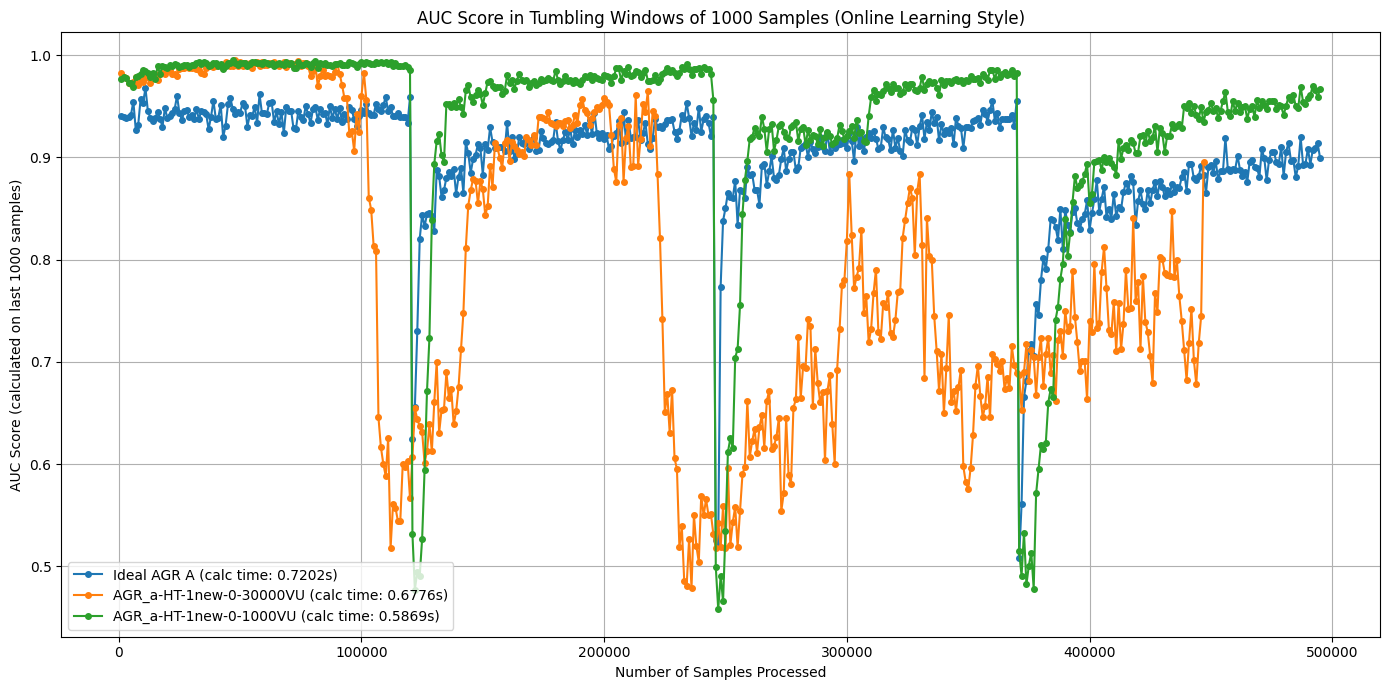

In [39]:
# Get AUC graphs

all_results_dfs = []
WINDOW_SIZE = 1000

EXPERIMENT_NAMES = [
                    # "AGR_a-HT-old-1000-10000VU", 
                    # "AGR_a-HT-old-1000-1000VU", 
                    "AGR_a-HT-1new-0-30000VU",
                    "AGR_a-HT-1new-0-1000VU",
                    ]

agr_a_real_df = pd.read_csv("C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\AGR_a_hoeffding_results.csv")
agr_a_real_df['experiment'] = 'Ideal AGR A'
all_results_dfs.append(agr_a_real_df)

# EXPERIMENT_NAMES = [
#                     "AGR_g-HT-old-1000-1000VU",
#                     "AGR_g-HT-old-1000-30000VU",
#                     "AGR_g-HT-1new-0-1000VU",
#                     "AGR_g-HT-1new-0-30000VU",
#                     ]


# agr_g_real_df = pd.read_csv("C:\\Users\\muhammad.aulia\\large-scale-online-learning\\MLOps-Architecture\\Serialization_Datasets\\experiment-results\\AGR_g_hoeffding_results.csv")
# agr_g_real_df['experiment'] = 'Ideal AGR G'
# all_results_dfs.append(agr_g_real_df)







BASE_RESULTS_PATH = os.path.join("C:", os.sep, "Users", "muhammad.aulia", "large-scale-online-learning", "MLOps-Architecture", "Serialization_Datasets", "experiment-results")

def extract_tar_archives(experiment_directory: str):
    """
    Finds and extracts all .tar.gz files in the specified directory.

    Args:
        experiment_directory (str): The path to the directory containing tar.gz files.
    """
    print(f"Searching for archives in: {experiment_directory}")
    # Find all files ending with .tar.gz
    archive_files = glob.glob(os.path.join(experiment_directory, "*.tar.gz"))
    
    if not archive_files:
        print("No .tar.gz archives found.")
        return

    for archive_path in archive_files:
        # Check if the output directory contains the extracted files (skip if exists)
        output_file = os.path.splitext(os.path.splitext(archive_path)[0])[0]  # Remove .tar.gz
        # If the output directory or a known file inside it exists, skip extraction
        if os.path.exists(output_file):
            print(f"Skipping extraction for {os.path.basename(archive_path)} (already extracted).")
            continue
        print(f"Extracting: {os.path.basename(archive_path)}...")
        try:
            with tarfile.open(archive_path, "r:gz") as tar:
                tar.extractall(path=experiment_directory)
        except tarfile.ReadError as e:
            print(f"Error reading archive {archive_path}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred during extraction: {e}")

def load_and_preprocess_results(experiment_name: str, base_path: str) -> pd.DataFrame:
    """
    Loads and preprocesses the 'for_auc.csv' file for a given experiment.

    Args:
        experiment_name (str): The name of the experiment.
        base_path (str): The base directory for all experiments.

    Returns:
        pd.DataFrame: A preprocessed DataFrame with results.
    """
    # Construct the path to the specific CSV file
    csv_path = os.path.join(base_path, experiment_name, "update-results", "app", "for_auc.csv")
    
    if not os.path.exists(csv_path):
        print(f"Warning: CSV file not found at {csv_path}")
        return pd.DataFrame() # Return an empty DataFrame if file doesn't exist

    # Load the data, assuming no header
    results_df = pd.read_csv(csv_path, header=None)
    
    # Assign clear column names
    results_df.columns = ["timestamp", "ground_truth", "prediction"]
    
    # Convert UNIX timestamp to a readable, localized datetime string
    results_df['timestamp'] = pd.to_datetime(results_df['timestamp'], unit='s') \
                                .dt.tz_localize('UTC') \
                                .dt.tz_convert('Asia/Jakarta') \
                                .dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Tag the data with the experiment name for easy identification
    results_df['experiment'] = experiment_name
    
    return results_df

def calculate_tumbling_window_auc(results_df: pd.DataFrame, window_size: int) -> list:
    """
    Calculates AUC over non-overlapping ("tumbling") windows of a specified size.
    This is much more efficient than iterating row by row.

    Args:
        results_df (pd.DataFrame): DataFrame with 'ground_truth' and 'prediction'.
        window_size (int): The number of rows in each window to calculate AUC.

    Returns:
        list: A list of AUC scores for each window.
    """
    if results_df.empty:
        return []

    # Create a grouper array that assigns each row to a window
    grouper = np.arange(len(results_df)) // window_size

    def auc_for_group(group):
        """Helper function to safely calculate AUC for a single group."""
        # AUC is only defined if there are both positive and negative samples
        if len(group['ground_truth'].unique()) > 1:
            return roc_auc_score(group['ground_truth'], group['prediction'])
        else:
            # Return NaN (Not a Number) if AUC is undefined for the window
            return np.nan

    # Group the DataFrame by the window index and apply the AUC calculation
    auc_scores = results_df.groupby(grouper).apply(auc_for_group)
    
    return auc_scores.tolist()


"""
Main function to orchestrate the data processing and plotting workflow.
"""


# --- 1. Extract and Load Data for Each Experiment ---
for name in EXPERIMENT_NAMES:
    update_dir = os.path.join(BASE_RESULTS_PATH, name, "update-results")
    extract_tar_archives(update_dir)
    df = load_and_preprocess_results(name, BASE_RESULTS_PATH)
    if not df.empty:
        all_results_dfs.append(df)


if len(all_results_dfs) < 2:
    print("Not enough data to perform comparison. Exiting.")

# --- 3. Calculate AUC and Plot Results ---
plt.figure(figsize=(14, 7))

for df in all_results_dfs:
    experiment_label = df['experiment'].iloc[0]
    print(f"Calculating AUC for {experiment_label}...")

    start_time = time.time()
    auc_scores = calculate_tumbling_window_auc(df, window_size=WINDOW_SIZE)
    end_time = time.time()
    
    duration = round(end_time - start_time, 4)
    print(f" -> Calculation finished in {duration} seconds.")

    # Generate x-axis values (e.g., 1000, 2000, 3000...)
    row_indices = np.arange(1, len(auc_scores) + 1) * WINDOW_SIZE
    
    # Plot the results
    plt.plot(row_indices, auc_scores, marker='o', linestyle='-', markersize=4, label=f"{experiment_label} (calc time: {duration}s)")

# --- 4. Finalize and Show Plot ---
plt.title(f'AUC Score in Tumbling Windows of {WINDOW_SIZE} Samples (Online Learning Style)')
plt.xlabel('Number of Samples Processed')
plt.ylabel(f'AUC Score (calculated on last {WINDOW_SIZE} samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
